# Autoencoder for Nakagami-m Fading Model (Dense Layer Part)
# 
# target to CCNCPS 2025  --> Bit-Wise Autoencoder in Communication for Cyber-Physical Systems (CPS)

# Deep learning-based autoencoder architectures replace traditional signal modulation and demodulation, improving spectral efficiency and robustness to noise and interference. In Industrial IoT (IIoT), wireless communication occurs in challenging environments such as factories, warehouses, and power plants, which introduce complex channel effects. To accurately model these environments, different wireless channel models are used.

In [2]:
import gc
gc.collect()

550

In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense

import matplotlib.image as mpimg
from matplotlib.patches import Ellipse

from PIL import Image, ImageEnhance

# Define Channel Layer

In [227]:
class Channel(Layer):

    def __init__(self, Nc=1, **kwargs):
        super(Channel, self).__init__(**kwargs)
        
        self.Nc = Nc
        
    def call(self, x, SNR_db, nakagamiFading):
                    
        noise_std = tf.sqrt( 1 / tf.pow(10., SNR_db/10.0))
        noise_r = tf.random.normal(shape = [tf.shape(x)[0], self.Nc], stddev = 1) * noise_std * 2
        noise_i = tf.random.normal(shape = [tf.shape(x)[0], self.Nc], stddev = 1) * noise_std * 2
        self.noise_cplx = tf.complex(noise_r, noise_i)


        # call function 
        # phi = gen_phase_noise(tf.shape(x), self.lw)

        # # Add phase noise
        # phi = phase_noise_rad
        # print("phase_noise_rad: ", phase_noise_rad)
        nakagamiFading_cplx = tf.complex(tf.zeros_like(nakagamiFading), nakagamiFading)
        # phi_2d = tf.expand_dims(phi_cplx, axis=-1)
        # print("phi_2d: ", phi_2d)
        self.y = x * nakagamiFading_cplx + self.noise_cplx
            
        return self.y

# matlab-based 
# def nakagamiFading_ch(PL, distance_range, Transmit_dB, m, input_signal):
#     """Generate Nagakami-m Channel Effect"""
#     # Calculate path loss for each distance in the range using vectorized operation
#     path_loss = PL + 10 * n * log10(distance_range);

#     # Calculate received power for each distance
#     receivedPower_dB = Transmit_dB - path_loss;
#     receivedPower_linear = 10 .^ (receivedPower_dB / 10);
    
#     # spread parameter
#     omega = abs(receivedPower_linear);

#     # Nagakami Probability Distribution
#     pd = makedist('Nakagami', 'mu', m, 'omega', omega(i));

#     nakagamiFading1 = random(pd, length(input_signal),1);
    
#     return nakagamiFading

def nakagami_fading_ch(PL, n, distance_range, Transmit_dB, m, shape):
    """Generate Nakagami-m Channel Effect using TensorFlow"""
    
    # Calculate path loss for each distance in the range
    path_loss = PL + 10 * n * tf.math.log(distance_range) / tf.math.log(10.0)
    
    # Calculate received power for each distance
    receivedPower_dB = Transmit_dB - path_loss
    receivedPower_linear = tf.pow(10.0, receivedPower_dB / 10.0)
    
    # print(f"\nreceivedPower_dB={receivedPower_dB} receivedPower_linear= ", tf.sqrt(receivedPower_linear).numpy)
    
    # Spread parameter
    omega = tf.abs(receivedPower_linear)

    # # Get the length dynamically for TensorFlow tensors
    # input_length = tf.shape(input_signal)[0]
    
    # Generate Nakagami fading samples
    nakagamiFading = tf.random.gamma(shape=[shape], alpha=m, beta=1.0/m) * tf.sqrt(omega)
    
    return tf.reshape(nakagamiFading, (-1, 1))

### Define the model

In [229]:
class Autoencoder(Model):

    def __init__(self, K, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        self.K = K
        self.powtwo = tf.constant([float(tf.pow(2, i)) for i in range(self.K)])
        
        self.tx_layer_1 = Dense(256, activation='relu') 
        self.tx_layer_2 = Dense(256, activation='relu') 
        self.tx_layer_3 = Dense(256, activation='relu') 
        self.tx_layer_4 = Dense(256, activation='relu') 
        self.tx_layer_5 = Dense(256, activation='relu') 
        self.tx_layer_6 = Dense(2 * tf.pow(2, K)) 
        
        self.channel = Channel() 
        
        self.rx_layer_1 = Dense(256, activation='relu') 
        self.rx_layer_2 = Dense(256, activation='relu') 
        self.rx_layer_3 = Dense(256, activation='relu') 
        self.rx_layer_4 = Dense(256, activation='relu') 
        self.rx_layer_5 = Dense(256, activation='relu') 
        self.rx_layer_6 = Dense(self.K, activation='sigmoid') 
    
    def call(self, bits, SNR_db, nakagamiFading):        
        ### Transmitter
        self.x = tf.concat([SNR_db, nakagamiFading], axis=1)  # Concatenate SNR_db and nakagamiFading
        self.x = self.tx_layer_1(self.x)
        self.x = self.tx_layer_2(self.x)
        self.x = self.tx_layer_3(self.x)
        self.x = self.tx_layer_4(self.x)
        self.x = self.tx_layer_5(self.x)
        self.x = self.tx_layer_6(self.x)
        self.x = tf.complex(self.x[:,:(tf.pow(2,K))], self.x[:,(tf.pow(2,K)):])

        ### Normalization & Channel
        bit = tf.math.reduce_sum(bits * self.powtwo, 1)
        bit = tf.cast(bit, tf.int32)
        bit = tf.one_hot(bit, tf.pow(2, K))
        self.energy = tf.reduce_mean(tf.square(tf.abs(self.x)), axis=1, keepdims=True)
        self.x = self.x/tf.cast(tf.sqrt(self.energy),tf.complex64)
        self.x = tf.reduce_sum(tf.math.multiply(self.x, tf.cast(bit,tf.complex64)), axis=1, keepdims=True)
        self.y = self.channel(self.x, SNR_db, nakagamiFading)
        self.yc = tf.concat([tf.math.real(self.y), tf.math.imag(self.y)], axis=1)
        
        ### Receiver
        self.y = tf.concat([SNR_db, nakagamiFading, self.yc], axis=1)
        self.y = self.rx_layer_1(self.y)
        self.y = self.rx_layer_2(self.y)
        self.y = self.rx_layer_3(self.y)
        self.y = self.rx_layer_4(self.y)
        self.y = self.rx_layer_5(self.y)
        self.pb = self.rx_layer_6(self.y)
        
        return self.pb

# Define functions

In [230]:
# These functions were taken from https://github.com/mgoutay/ml_course/tree/master and modified according to paper purposes
def visualize (model, SNRs_db, nakagamiFading, distance):
    K = model.K
    msg = np.arange(2**K)
    res = []
    for i in range(2**K):
        temp=msg[i]
        res_ = []
        for j in 2**np.linspace(K-1, 0, K):
            if temp - j >= 0 :
                res_.append(1)
                temp -= j
            else:
                res_.append(0)
        res.append(res_)
    bits = np.array(res, dtype=np.float32) 
    
    fig, axes = plt.subplots(1, len(SNRs_db), figsize=(len(SNRs_db)*7, 6))
    if len(SNRs_db) == 1 :
        axes = np.array([axes])
    for i in range(len(SNRs_db)):
                   
        llrs = model(bits, tf.ones(shape=(tf.shape(bits)[0], 1))*SNRs_db[i], nakagamiFading)
        x = model.x
        if tf.size(tf.shape(x)) == 1 :
            x = x[:, tf.newaxis]
                   
        # axes[i].set_title('S/N = '+str(SNRs_db[i]))
        for j in range(2**K):
            axes[i].scatter(np.real(x[j, 0]), np.imag(x[j, 0]), s=100)
            # axes[i].text(np.real(x[j, 0])+0.05, np.imag(x[j, 0])+0.05, np.binary_repr(j, width=K), fontsize=12)
            axes[i].set_xlim([-1.6, 1.6])
            axes[i].set_ylim([-1.6, 1.6])
    plt.savefig('const_dense_QAM__dis_' + str(distance), transparent=True)

def evaluate_rate(model, SNRs_eval, nakagamiFading, DS_size=10240):
    
    print('K = '+str(model.K))
    
    DS_bits, DS_SNRs = gen_DS(DS_size, model.K, 1., 1.)
    TF_DS_test = tf.data.Dataset.from_tensor_slices((DS_bits, DS_SNRs)).shuffle(DS_size).batch(1024)
    
    print("SNR (dB) = ", end='')
    rates = []
    for snr_i in SNRs_eval :

        rates_temp = []
        for step, (bits, SNRs) in enumerate(TF_DS_test):
            pb_eq_1 = model(bits, SNRs*snr_i, nakagamiFading)
            err_loss =  tf.reduce_mean(tf.keras.losses.binary_crossentropy(bits, pb_eq_1))
            rates_temp.append(model.K-err_loss.numpy())
        rates.append(np.mean(rates_temp))
        print(str(snr_i)+', ', end='')
    print('')
    return rates

def gen_DS(DS_size, K, SNR_db_low, SNR_db_high):  
    DS_bits = tf.random.uniform(shape=[DS_size, K], minval=0, maxval=2, dtype=tf.int32)
    DS_SNRs = tf.random.uniform(shape=[DS_size, 1], minval=SNR_db_low, maxval=SNR_db_high)
    return tf.cast(DS_bits, tf.float32), DS_SNRs

### Generate Tensorflow datasets

In [115]:
K = 2
DS_size_train = 100000+352
DS_size_test = 1000
batch_size = 1024
DS_bits, DS_SNRs_db = gen_DS(DS_size_train+DS_size_test+24, K, SNR_db_low=-5, SNR_db_high=30)
TF_DS_train = tf.data.Dataset.from_tensor_slices((DS_bits[:DS_size_train], DS_SNRs_db[:DS_size_train])).shuffle(10000).batch(batch_size)
TF_DS_test = tf.data.Dataset.from_tensor_slices((DS_bits[DS_size_train:], DS_SNRs_db[DS_size_train:])).batch(batch_size)

## training loop 

Distance(km)=  0.5
Epoch 1: 0.04270285740494728, Epoch 2: 0.04118267819285393, Epoch 3: 0.037001416087150574, Epoch 4: 0.03356952220201492, Epoch 5: 0.035630859434604645, Epoch 6: 0.031165912747383118, Epoch 7: 0.03739936649799347, Epoch 8: 0.03332654386758804, Epoch 9: 0.03721071034669876, Epoch 10: 0.031588807702064514, Epoch 11: 0.03965792432427406, Early stopping triggered
Done
K = 2
SNR (dB) = 15.0, 
Rate_0_5 = np.array( [1.9933442974463105])
BER_0_5 = np.array( [0.0019575])
 ---------------------------------------------------------------------------------------------------------------------


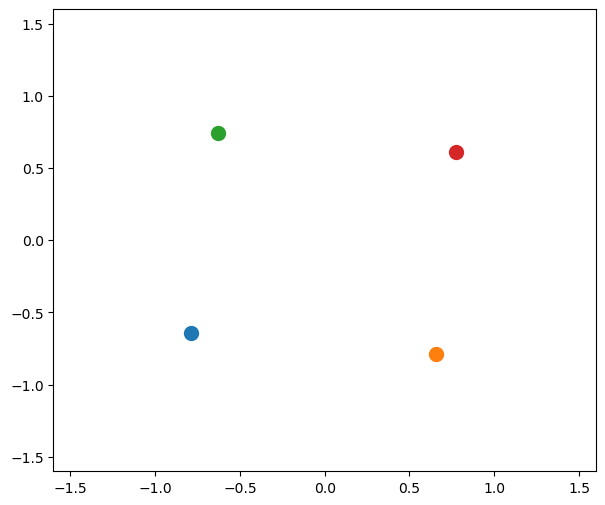

In [235]:
# Parameters nakagami_fading
PL = 0.001; # Path loss at 1k reference distance (dB)
n = 3; # Path loss exponent for urban area
# n = 6; # Dense Urban Area
# distance_range = 2.; # 2:0.5:5Range of distances from 2 to 5 kilometers
# distance_range = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1])
distance_range = np.array([0.5])

# Transmit power
Transmit_dB = 0; # 0 dB is taken as reference at which QAM Signal is generated

m = 2 # meu: Shape parameter for Nakagami Distribution

# 𝑚 controls fading severity:
# Small 𝑚 → More severe fading. ~ 0.5 Severe fading (deep fades)
# Large 𝑚 → Less fading. ~ 3 Weak fading (closer to Rician)
# 𝑛 controls path loss:
# Small 𝑛 → Less path loss (stronger signal over distance). ~2 Moderate path loss
# Large 𝑛 → More path loss (weaker signal over distance). ~6 High path loss (Dense urban, tunnels, forests)

SNRs_eval = np.array([5., 10., 15., 20., 25., 30.])
SNRs_eval = np.array([15.])

bs_eval = 1000000

# Define the optimizer with the learning rate schedule
# Define the learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_func = tf.keras.losses.BinaryCrossentropy() # Loss function

nb_epoch = 100


### Training loop 
for dr in distance_range: 

    dr = np.float32(dr)

    print("Distance(km)= ", dr)
    # Instantiate an autoencoder 
    autoencoder = Autoencoder(K)

    # generate nakagami_fading for learning, feed into AE encoder and AE decoder 
    nakagami_fading = nakagami_fading_ch(PL, n, dr, Transmit_dB, m, batch_size)

    ### Training loop
    # Define early stopping parameters
    patience = 5  # Number of steps to wait for improvement
    min_delta = 0.001  # Minimum change to qualify as an improvement
    best_loss = float('inf')
    wait = 0

    for epoch in range(nb_epoch):
        
        # Iterate over the batches of the dataset.
        for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_train):
            # print("DS_SNRs_db size = ", DS_SNRs_db.shape)
            
            # Open a GradientTape.
            with tf.GradientTape() as tape:
    
                # Forward pass.
                probas = autoencoder(DS_bits, DS_SNRs_db, nakagami_fading)
    
                # Loss value for this batch.
                loss_value = loss_func(y_true=DS_bits, y_pred=probas)
    
            # Get gradients of loss wrt the weights.
            gradients = tape.gradient(loss_value, autoencoder.trainable_weights)
    
            # Update the weights of our linear layer.
            optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
        
        #Test the model on the test datasets
        test_loss = 0.
        for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_test):
            probas = autoencoder(DS_bits, DS_SNRs_db, nakagami_fading)
            test_loss += loss_func(y_true=DS_bits, y_pred=probas)
            test_loss /= (step + 1)
        print(f'Epoch {epoch + 1}: {test_loss.numpy()}', end=', ')
        
        # Check for early stopping
        if test_loss < best_loss - min_delta:
            best_loss = test_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered")
                break
    print('Done')
    
    # Evaluation by calculating the AIR
    rate_autoencoder = evaluate_rate(autoencoder, SNRs_eval, nakagami_fading)
    # print("Rate",int(dr)," = np.array(", rate_autoencoder, end=')')
    print(f"Rate_{str(dr).replace('.', '_')} = np.array(", rate_autoencoder, end=')')
    
    # Evaluation by calculating BER
    results=[] 
    nakagami_fading = nakagami_fading_ch(PL, n, dr, Transmit_dB, m, bs_eval)    
    for eval_snr in SNRs_eval:
        batch_bits = tf.random.uniform(shape=[bs_eval, K], minval=0, maxval=2, dtype=tf.int32)
        batch_snr = eval_snr*tf.ones(shape=[bs_eval, 1]) 
        p_b = autoencoder(tf.cast(batch_bits, tf.float32), tf.cast(batch_snr, tf.float32), nakagami_fading)
        b_hat = tf.cast(tf.sign(p_b-0.5)/2+1, dtype=tf.int32)
        # b_hat = tf.cast(tf.sign(p_b-0.5)/2.+0.5, dtype=tf.int32)
        ber = tf.reduce_sum(tf.abs(b_hat - batch_bits))/(bs_eval*K)
        results.append(ber.numpy())
        # print(eval_snr, end=', ')
    # print("BER = np.array(", results, end=') ')
    print(f"\nBER_{str(dr).replace('.', '_')} = np.array(", results, end=')')
    print("\n ---------------------------------------------------------------------------------------------------------------------")

    # Visualize
    visualize(autoencoder, SNRs_db=[25], nakagamiFading=nakagami_fading[:4], distance=str(dr).replace('.', '_'))

In [255]:
distance_range = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1])
# n_range = np.array([2, 3, 4, 5, 6]) 
# m_range = np.array([0.5, 1, 2, 3, 4])
n = 2
m = 0.5
results_rate=[]
results_ber=[]
snr_d = 15.0

batch_bits = tf.random.uniform(shape=[bs_eval, K], minval=0, maxval=2, dtype=tf.int32)
batch_snr = snr_d*tf.ones(shape=[bs_eval, 1])

for dr in distance_range:
    dr = np.float32(dr)
    nakagami_fading = nakagami_fading_ch(PL, n, dr, Transmit_dB, m, batch_size)
    rate_autoencoder = evaluate_rate(autoencoder, SNRs_eval, nakagami_fading)
    results_rate.append(rate_autoencoder[0])
    
    # BER
    nakagami_fading = nakagami_fading_ch(PL, n, dr, Transmit_dB, m, bs_eval) 
    p_b = autoencoder(tf.cast(batch_bits, tf.float32), tf.cast(batch_snr, tf.float32), nakagami_fading)
    b_hat = tf.cast(tf.sign(p_b-0.5)/2+1, dtype=tf.int32)
    # b_hat = tf.cast(tf.sign(p_b-0.5)/2.+0.5, dtype=tf.int32)
    ber = tf.reduce_sum(tf.abs(b_hat - batch_bits))/(bs_eval*K)
    results_ber.append(ber.numpy())

print(f"\nRate_n_{str(n)}_m_{str(m).replace('.', '_')} = np.array(", results_rate, end=')')
print(f"\nBER_n_{str(n)}_m_{str(m).replace('.', '_')} = np.array(", results_ber, end=')')

K = 2
SNR (dB) = 15.0, 
K = 2
SNR (dB) = 15.0, 
K = 2
SNR (dB) = 15.0, 
K = 2
SNR (dB) = 15.0, 
K = 2
SNR (dB) = 15.0, 
K = 2
SNR (dB) = 15.0, 

Rate_n_2_m_0_5 = np.array( [1.6747456789016724, 1.4711605608463287, 1.3788316249847412, 1.3312339067459107, 1.267459511756897, 1.2419116973876954])
BER_n_2_m_0_5 = np.array( [0.1449395, 0.2340325, 0.2854055, 0.319772, 0.3449155, 0.365073])

In [242]:
Rate_m_2 = np.array( [1.9890486977994442, 1.992771371314302, 1.993556533427909, 1.996399874589406, 1.9975085543934257, 1.9980236445204356, 1.997638898214791, 1.9992359334544745, 1.999505006556865])

0.5

In [3]:
# varying n, fixing m=2 trained at n=3 and m=2
distance_range = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1])
# Rate_n_2_m_2 = np.array( [1.999477475861204, 1.9953953111777083, 1.9910139284096657, 1.9830647647380828, 1.9691528150811792, 1.950379391759634])
Rate_n_2_m_2 = np.array( [1.9991139077377738, 1.9968913982040248, 1.9940901365596801, 1.9823174556717276, 1.963854874484241, 1.94000834967196])
BER_n_2_m_2 = np.array( [0.0001875, 0.0014285, 0.003679, 0.0069135, 0.01089, 0.02126])
# Rate_n_3_m_2 = np.array( [1.9999476532013432, 1.9987489867489785, 1.9960983979981393, 1.9851088744588197, 1.9721291163936256, 1.9508066415786742])
Rate_n_3_m_2 = np.array( [1.9999975698112507, 1.9986256642907392, 1.9952578517375514, 1.9859011169523, 1.9737425994127988, 1.944543245434761])
BER_n_3_m_2 = np.array( [1.3e-05, 0.000459, 0.001977, 0.005087, 0.009995, 0.019742])
Rate_n_4_m_2 = np.array( [1.9999999985479064, 1.9994713727544877, 1.9965160673484206, 1.9881633112691344, 1.975491145811975, 1.9450512532144786])
BER_n_4_m_2 = np.array( [1.5e-06, 0.000118, 0.0009835, 0.0036365, 0.0090145, 0.018183])
Rate_n_5_m_2 = np.array( [2.0, 1.9999416199685585, 1.9994164230040041, 1.991000940464437, 1.9795104729011654, 1.949696059897542])
BER_n_5_m_2 = np.array( [0.0, 3.35e-05, 0.000481, 0.002576, 0.008195, 0.0169055])
Rate_n_6_m_2 = np.array( [2.0, 1.9999997910322833, 1.9999332099454477, 1.9932574360165745, 1.9808046150952578, 1.9493653912097215])
BER_n_6_m_2 = np.array( [0.0, 1.05e-05, 0.000237, 0.0017645, 0.007478, 0.015448])

# varying m, fixing n=2
Rate_n_2_m_3 = np.array( [1.99999991545424, 1.9999532179404924, 1.9996309567533899, 1.9994545457622734, 1.999099742533872, 1.9980421099229715])
BER_n_2_m_3 = np.array( [0.0, 1.15e-05, 9.3e-05, 0.0002125, 0.0004075, 0.0006935])
Rate_n_2_m_4 = np.array( [1.9999999815020124, 1.9999999884991382, 1.9999943697359412, 1.9999797648316417, 1.999893370402424, 1.9998508761251288])
BER_n_2_m_4 = np.array( [0.0, 0.0, 1.5e-06, 4e-06, 6.5e-06, 2.35e-05])
Rate_n_2_m_1 = np.array( [1.9449735324829818, 1.8798270270228385, 1.8103035554289817, 1.7369469061493874, 1.672072783112526, 1.6424828916788101])
BER_n_2_m_1 = np.array( [0.0202055, 0.0569545, 0.089223, 0.1178605, 0.143708, 0.1667985])
Rate_n_2_m_0_5 = np.array( [1.6747456789016724, 1.4711605608463287, 1.3788316249847412, 1.3312339067459107, 1.267459511756897, 1.2419116973876954])
BER_n_2_m_0_5 = np.array( [0.1449395, 0.2340325, 0.2854055, 0.319772, 0.3449155, 0.365073])

C:\Users\z642291\AppData\Local\Temp\ipykernel_9228\3043031443.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(distance_range, np.log10(BER_n_5_m_2), 'co-', label='n=3')
C:\Users\z642291\AppData\Local\Temp\ipykernel_9228\3043031443.py:7: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(distance_range, np.log10(BER_n_6_m_2), 'm+-', label='n=2')
C:\Users\z642291\AppData\Local\Temp\ipykernel_9228\3043031443.py:18: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(distance_range, np.log10(BER_n_2_m_3), 'co-', label='m=3')
C:\Users\z642291\AppData\Local\Temp\ipykernel_9228\3043031443.py:19: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(distance_range, np.log10(BER_n_2_m_4), 'm+-', label='m=4')


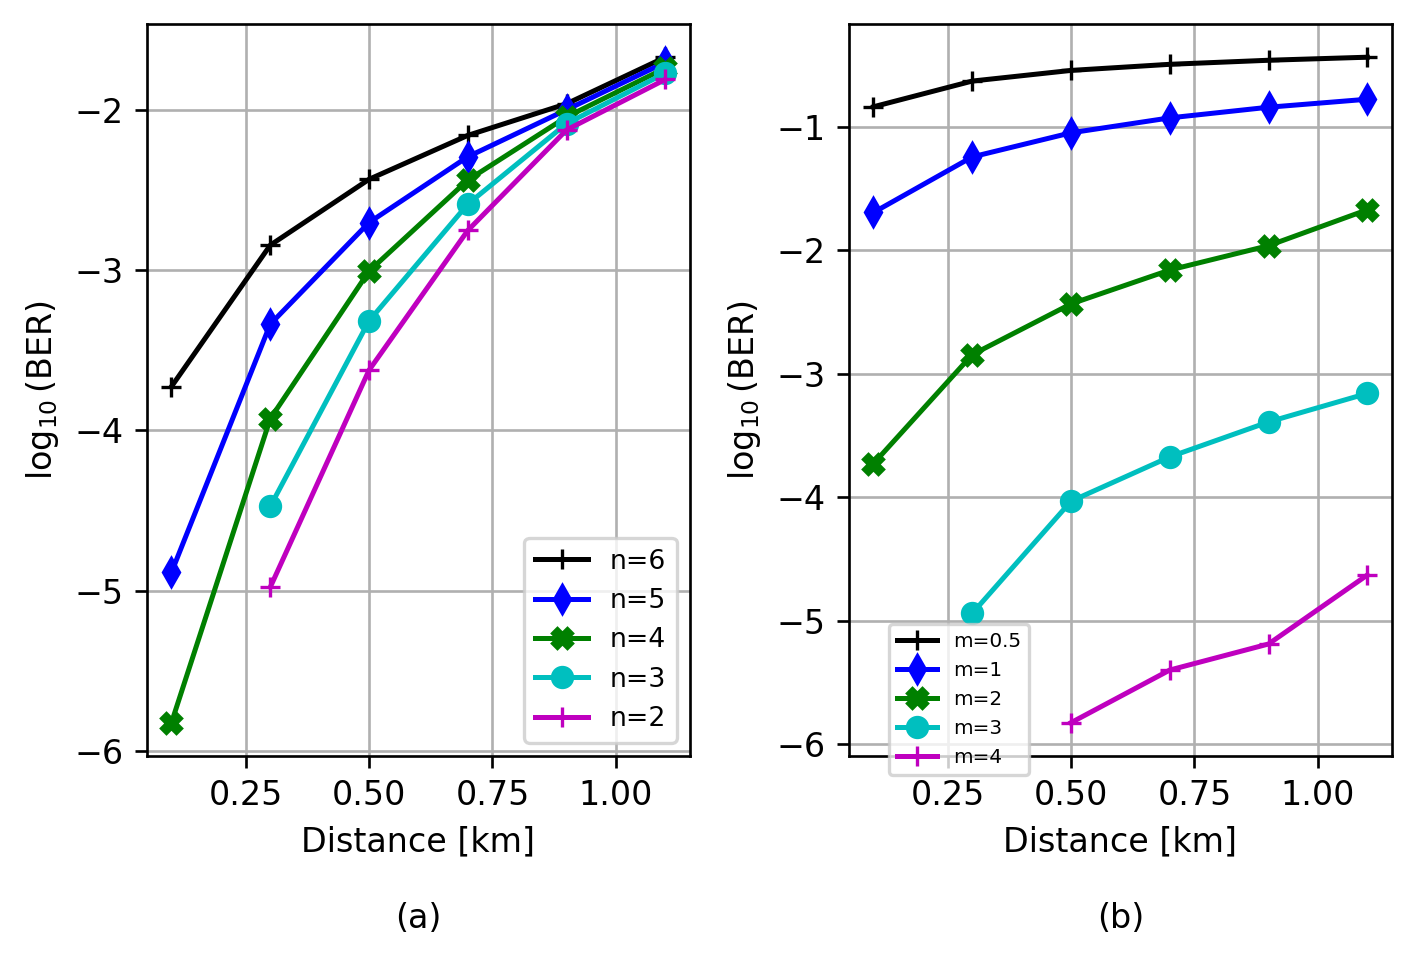

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), dpi=240)

ax1.plot(distance_range, np.log10(BER_n_2_m_2), 'k+-', label='n=6')
ax1.plot(distance_range, np.log10(BER_n_3_m_2), 'bd-', label='n=5')
ax1.plot(distance_range, np.log10(BER_n_4_m_2), 'gX-', label='n=4')
ax1.plot(distance_range, np.log10(BER_n_5_m_2), 'co-', label='n=3')
ax1.plot(distance_range, np.log10(BER_n_6_m_2), 'm+-', label='n=2')

ax1.set_xlabel('Distance [km]\n\n(a)')
ax1.set_ylabel(r'$\log_{10}(\mathrm{BER})$')
ax1.legend(fontsize=8,)
ax1.grid()
# ax1.set_title("Figure 1")

ax2.plot(distance_range, np.log10(BER_n_2_m_0_5), 'k+-', label='m=0.5')
ax2.plot(distance_range, np.log10(BER_n_2_m_1), 'bd-', label='m=1')
ax2.plot(distance_range, np.log10(BER_n_2_m_2), 'gX-', label='m=2')
ax2.plot(distance_range, np.log10(BER_n_2_m_3), 'co-', label='m=3')
ax2.plot(distance_range, np.log10(BER_n_2_m_4), 'm+-', label='m=4')

ax2.set_xlabel('Distance [km]\n\n(b)')
ax2.set_ylabel(r'$\log_{10}(\mathrm{BER})$')
ax2.legend(fontsize=6, loc='lower right', bbox_to_anchor=(0.35, -0.04))
ax2.grid()
# ax2.set_title("Figure 2")

# Show the figures
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.savefig('BER_4qam_n3_m2', transparent=True)
plt.show()

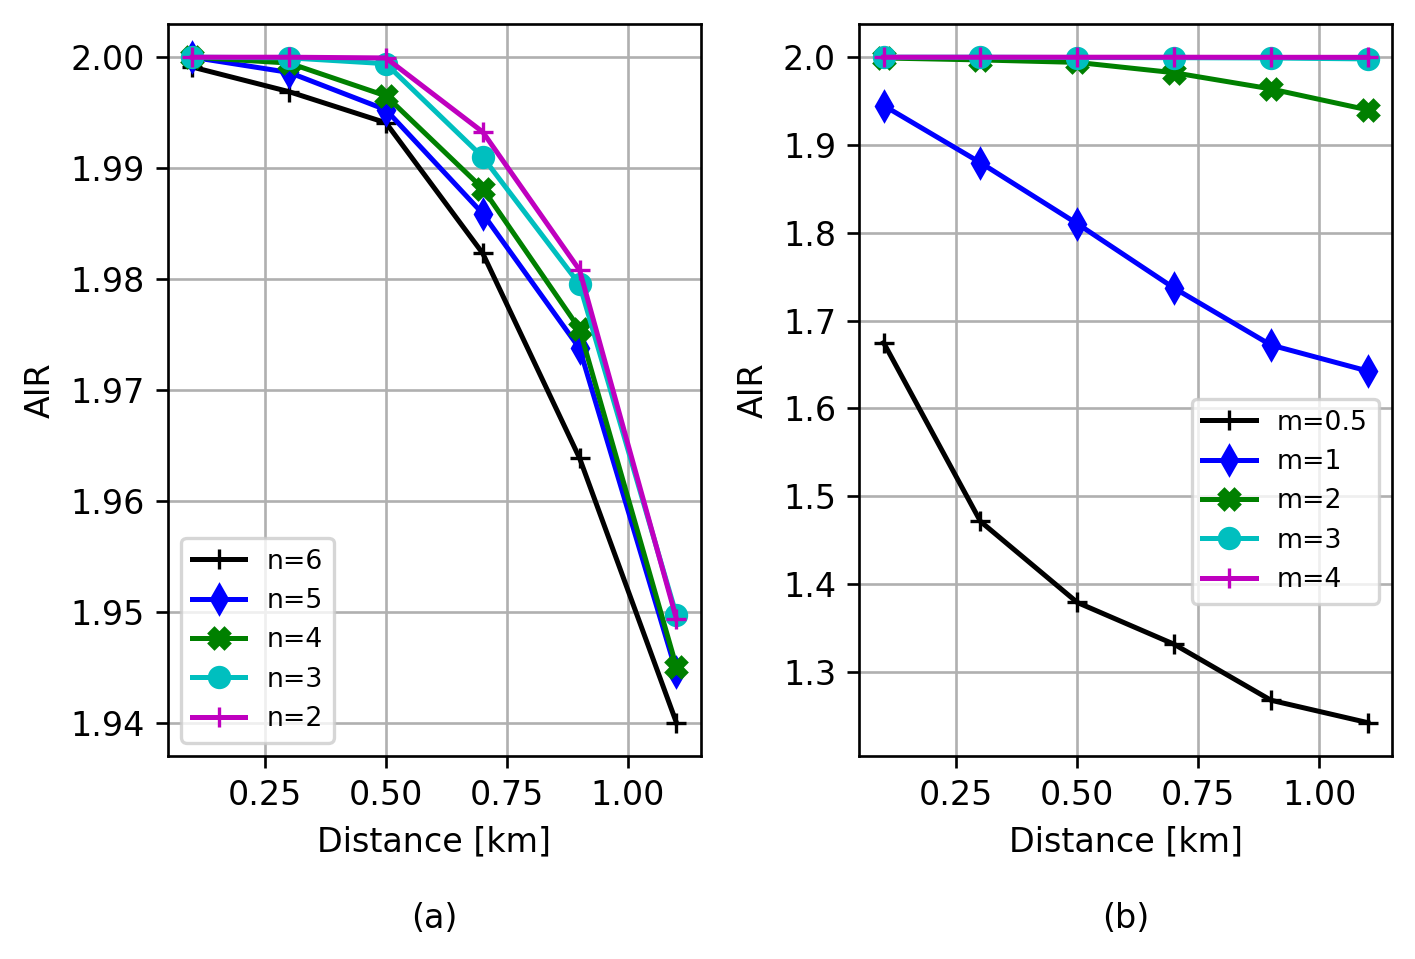

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), dpi=240)

ax1.plot(distance_range, Rate_n_2_m_2, 'k+-', label='n=6')
ax1.plot(distance_range, Rate_n_3_m_2, 'bd-', label='n=5')
ax1.plot(distance_range, Rate_n_4_m_2, 'gX-', label='n=4')
ax1.plot(distance_range, Rate_n_5_m_2, 'co-', label='n=3')
ax1.plot(distance_range, Rate_n_6_m_2, 'm+-', label='n=2')

ax1.set_xlabel('Distance [km]\n\n(a)')
ax1.set_ylabel('AIR')
ax1.legend(fontsize=8,)
ax1.grid()
# ax1.set_title("Figure 1")

ax2.plot(distance_range, Rate_n_2_m_0_5, 'k+-', label='m=0.5')
ax2.plot(distance_range, Rate_n_2_m_1, 'bd-', label='m=1')
ax2.plot(distance_range, Rate_n_2_m_2, 'gX-', label='m=2')
ax2.plot(distance_range, Rate_n_2_m_3, 'co-', label='m=3')
ax2.plot(distance_range, Rate_n_2_m_4, 'm+-', label='m=4')

ax2.set_xlabel('Distance [km]\n\n(b)')
ax2.set_ylabel('AIR')
ax2.legend(fontsize=8, loc='lower right', bbox_to_anchor=(1, 0.19))
ax2.grid()
# ax2.set_title("Figure 2")

# Show the figures
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.savefig('AIR_4qam_n3_m2', transparent=True)
plt.show()

In [12]:
# 4 QAM Path loss exponent for dense urban area
SNRs_eval = np.array([5., 10., 15., 20., 25., 30.])

Rate_0_1_d = np.array( [1.999998202020538, 1.9999988408396632, 1.9999988718599695, 1.999998773924176, 1.999998613797669, 1.9999977722765947])
BER_0_1_d = np.array( [4e-06, 3.5e-06, 4e-06, 4e-06, 6e-06, 1e-05])

Rate_0_3_d = np.array( [1.998908469293383, 1.9998040800401213, 1.9999024223459856, 1.9999459152122654, 1.9999188785628577, 1.9999308435470085])
BER_0_3_d = np.array( [0.000515, 0.0001965, 9.9e-05, 0.0001045, 0.0001455, 0.0001985])

Rate_0_5_d = np.array( [1.9886280450969935, 1.996715191262774, 1.9984112339559943, 1.9991035760263913, 1.999162653030362, 1.999186593707418])
BER_0_5_d = np.array( [0.004266, 0.0014635, 0.000496, 0.0001955, 0.0001195, 9.8e-05])

Rate_0_7_d = np.array( [1.9517082072794438, 1.9798981048166753, 1.9909689255990088, 1.9954877861542628, 1.9970731285633518, 1.9962914384203032])
BER_0_7_d = np.array( [0.019444, 0.0073305, 0.0028405, 0.0014965, 0.0013085, 0.0015965])

Rate_0_9_d = np.array( [1.8794748172163964, 1.9524390082806349, 1.9808524679392576, 1.9921787958126516, 1.9967256240546702, 1.997999403369613])
BER_0_9_d = np.array( [0.052109, 0.020996, 0.0076555, 0.0026575, 0.0008955, 0.000318])

Rate_1_1_d = np.array( [1.7891764625906945, 1.899950248003006, 1.9588232960551977, 1.9850639807991683, 1.9925154027063399, 1.994895340851508])
BER_1_1_d = np.array( [0.102671, 0.046704, 0.0188305, 0.0071955, 0.0031185, 0.001937])


In [13]:
# 4 QAM Path loss exponent for urban area
BER_0_1 = np.array( [0.000152, 8.2e-05, 0.000148, 0.000261, 0.0004275, 0.000596])
BER_0_3 = np.array( [0.003787, 0.0012715, 0.0003955, 0.000138, 4.15e-05, 1.7e-05])
BER_0_5 = np.array( [0.015064, 0.0054565, 0.0019575, 0.0008375, 0.0003535, 0.000123])
BER_0_7 = np.array( [0.0344735, 0.0131685, 0.0046815, 0.0016485, 0.000612, 0.0002755])
BER_0_9 = np.array( [0.0607705, 0.02508, 0.0093505, 0.0031985, 0.0011005, 0.0003875])
BER_1_1 = np.array( [0.09091, 0.040412, 0.0158725, 0.0059925, 0.002459, 0.0015275])

Rate_0_1 = np.array( [1.999954284958949, 1.9999926426527055, 1.99999777044967, 1.999999035236209, 1.9999986096298414, 1.9999959142599324])
Rate_0_3 = np.array( [1.9904347779694944, 1.9974382318090647, 1.999553818028653, 1.9997885008866434, 1.9998586902562239, 1.9998819300431934])
Rate_0_5 = np.array( [1.9662885922938584, 1.9855598824098706, 1.9945324591593816, 1.9968042940599844, 1.9969606667524205, 1.9973115321248769])
Rate_0_7 = np.array( [1.917771028727293, 1.965649513527751, 1.9849869437515735, 1.9944341180147602, 1.9962951724650337, 1.997718525887467])
Rate_0_9 = np.array( [1.8721814140677453, 1.9445435766130685, 1.9765666769817472, 1.991658427240327, 1.9969621926313266, 1.9984513214672917])
Rate_1_1 = np.array( [1.8016489386558532, 1.90266887024045, 1.9583124496042728, 1.9845016137696803, 1.9928487426601351, 1.994855050323531])

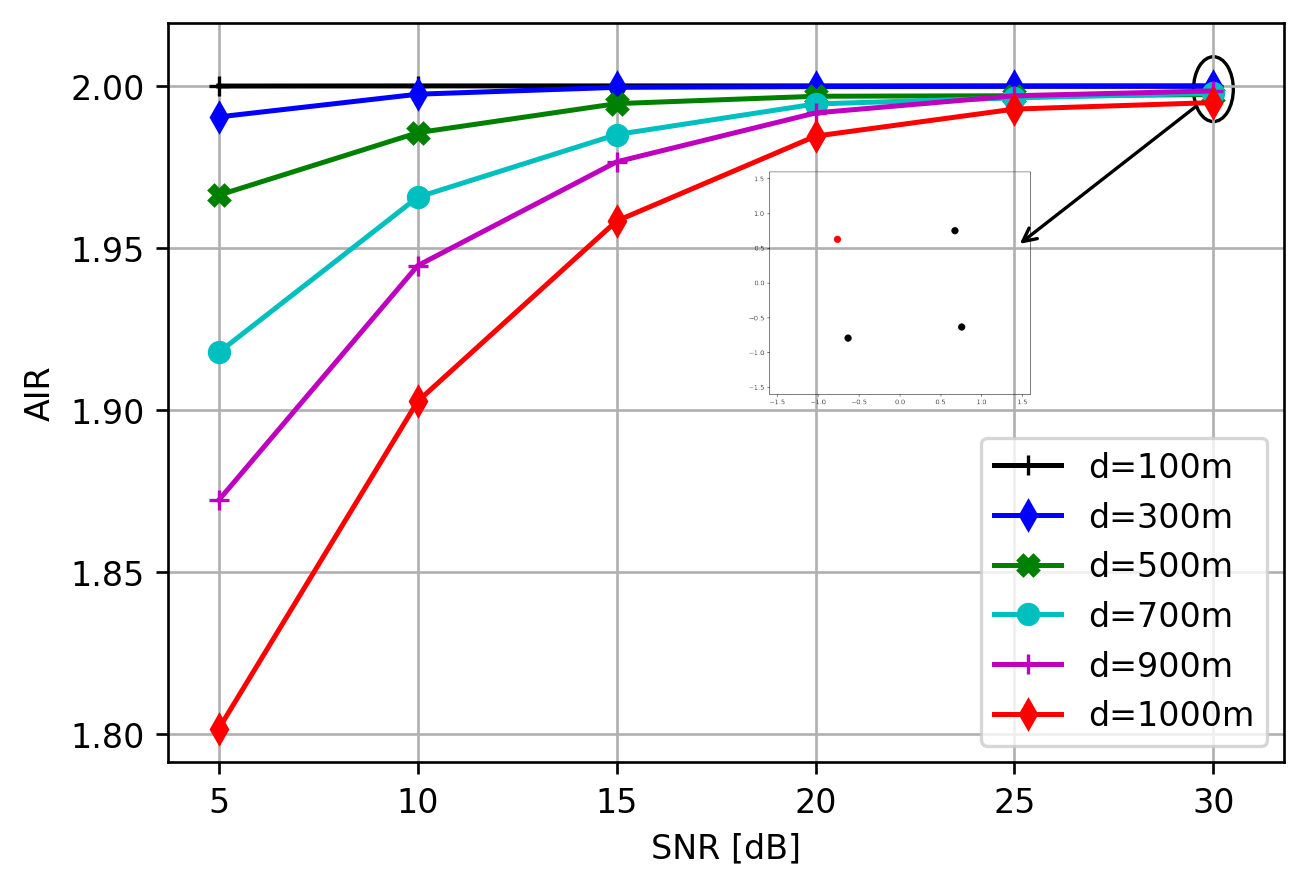

In [15]:
# AIR 4 QAM Path loss exponent for urban area
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=240, facecolor='w', edgecolor='k')

plt.plot(SNRs_eval, Rate_0_1, 'k+-', label='d=100m')
plt.plot(SNRs_eval, Rate_0_3, 'bd-', label='d=300m')
plt.plot(SNRs_eval, Rate_0_5, 'gX-', label='d=500m')
plt.plot(SNRs_eval, Rate_0_7, 'co-', label='d=700m')
plt.plot(SNRs_eval, Rate_0_9, 'm+-', label='d=900m')
plt.plot(SNRs_eval, Rate_1_1, 'rd-', label='d=1000m')

ellipse = Ellipse(xy=(30, 1.999), width=1, height=0.02, angle=0, edgecolor='black', facecolor='none', linestyle='-')
ax1.add_patch(ellipse)

plt.annotate('',xy=(25,1.95),xytext=(29.7,1.995),arrowprops=dict(arrowstyle='->', linestyle='solid', color='black'))

plt.xlabel('SNR [dB]')
plt.ylabel('AIR')
plt.legend()
plt.grid()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([0.48, 0.46, 0.3, 0.3])
img_lw_1m = Image.open('const_dense_QAM_Urban_30.png')

# Increase contrast (1.0 = original, >1.0 = higher contrast)
enhancer = ImageEnhance.Contrast(img_lw_1m)
img_high_contrast = enhancer.enhance(10.4)


ax2.axis('off')
ax2.imshow(img_high_contrast )

# plt.savefig('AIR_4qam_urban', transparent=True)

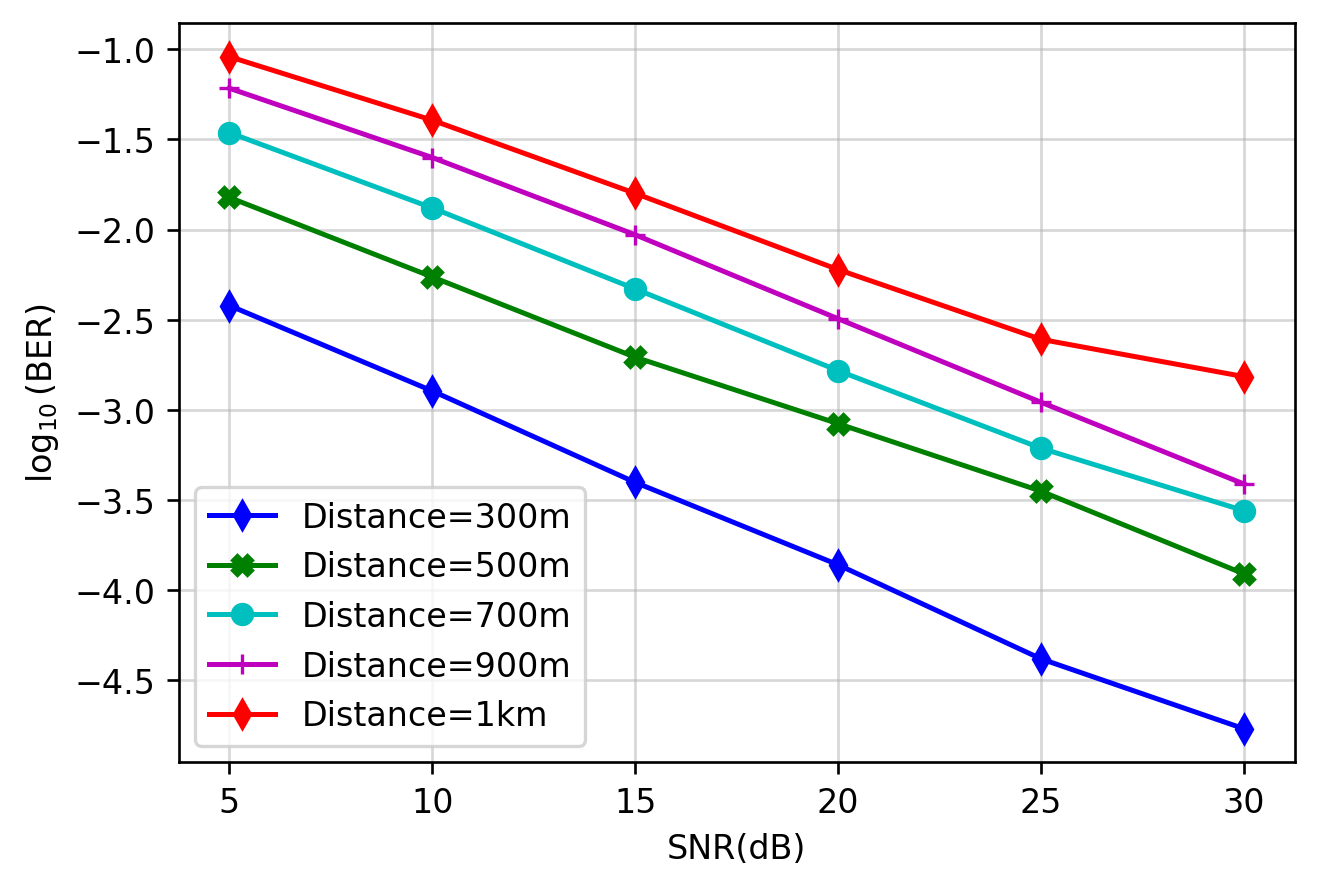

In [185]:
# BER 4 QAM
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=240, facecolor='w', edgecolor='k')
# plt.plot(SNRs_eval, np.log10(BER_0_1), 'k+-', label='Distance=100m')
plt.plot(SNRs_eval, np.log10(BER_0_3), 'bd-', label='Distance=300m')
plt.plot(SNRs_eval, np.log10(BER_0_5), 'gX-', label='Distance=500m')
plt.plot(SNRs_eval, np.log10(BER_0_7), 'co-', label='Distance=700m')
plt.plot(SNRs_eval, np.log10(BER_0_9), 'm+-', label='Distance=900m')
plt.plot(SNRs_eval, np.log10(BER_1_1), 'rd-', label='Distance=1km')

plt.xlabel('SNR(dB)')
plt.ylabel(r'$\log_{10}(\mathrm{BER})$')
plt.legend(loc='lower left')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)
# plt.savefig('BER_4qam_urban', transparent=True)

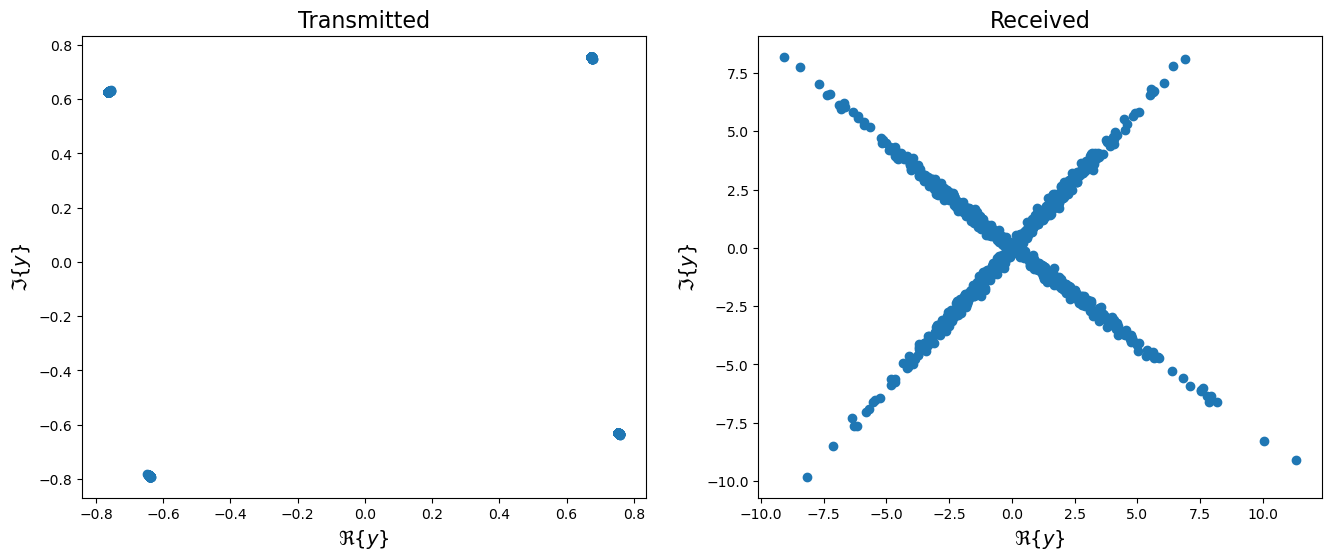

In [197]:
# Show channel input/output constellation

nakagami_fading = nakagami_fading_ch(PL, n, dr, Transmit_dB, m, bs_eval) 
SNRs_eval = np.array([25.]) 

# llrs 
llrs = autoencoder(DS_bits, tf.ones(shape=(tf.shape(DS_bits)[0], 1))*SNRs_eval, nakagami_fading[:1024])

# taking the labeling bits and convert it to symboles (1 to 16) and used it as c color 
sym_transmitted = autoencoder.x
sym_received = autoencoder.yc
# tf.autograph.set_verbosity(0)

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.scatter(tf.math.real(sym_transmitted), tf.math.imag(sym_transmitted))
# plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=14)
plt.ylabel(r'$\Im\{y\}$',fontsize=14)
plt.title('Transmitted',fontsize=16)
plt.subplot(1, 2, 2)
plt.scatter(sym_received[:,0], sym_received[:,1])
# plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=14)
plt.ylabel(r'$\Im\{y\}$',fontsize=14)
plt.title('Received',fontsize=16)
# plt.savefig('Tx_Rx_25dB_800km_2.png')
plt.show()

### Evaluate the trained model

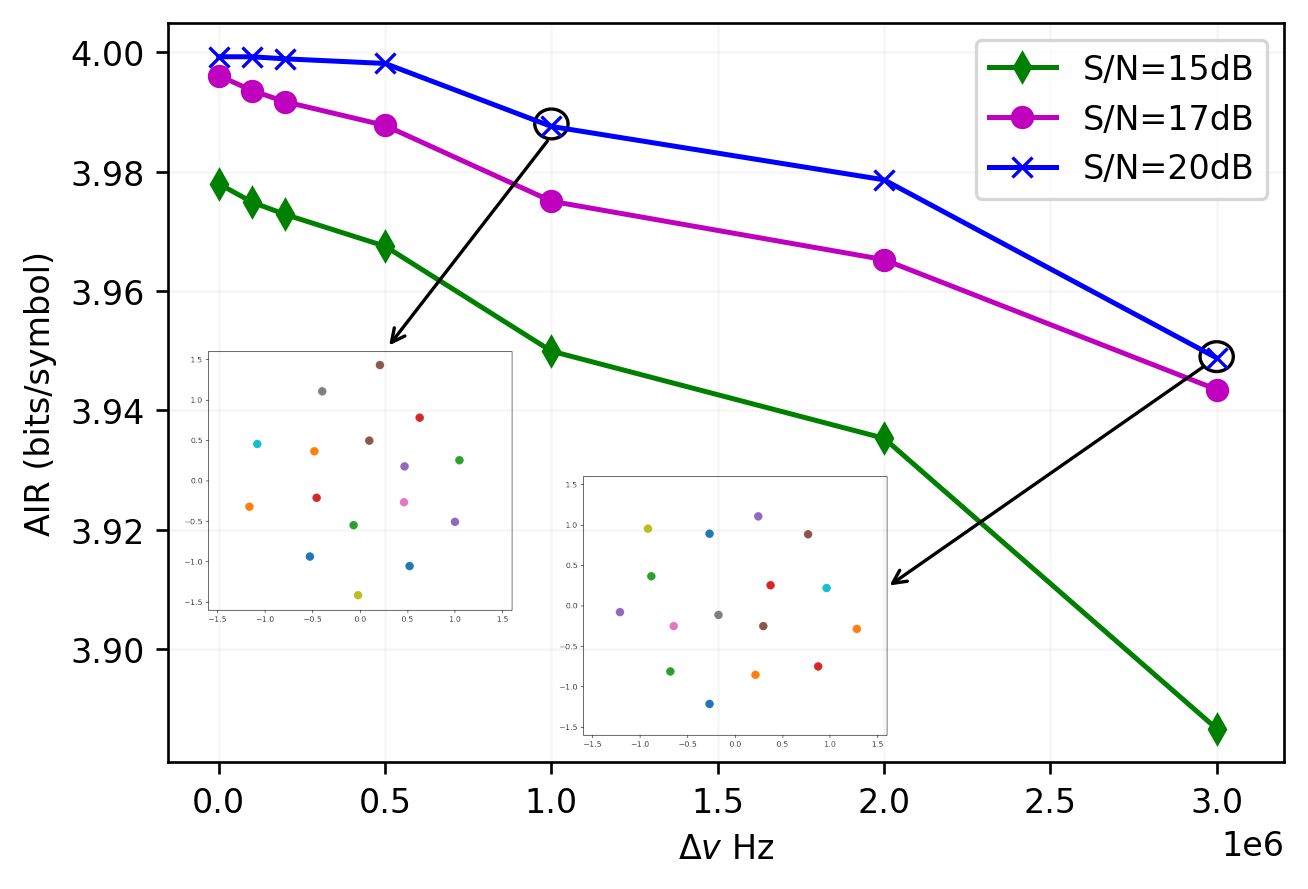

In [178]:
# BMI bits/symbol vs linewidth, in different SNR 15, 20

import matplotlib.image as mpimg
from matplotlib.patches import Ellipse

linewidth_eva = np.array( [0, 100e3, 200e3, 500e3, 1000e3, 2000e3, 3000e3])
Rate_snr_15_d = np.array( [3.9779747001603244 ,3.9748868754655125, 3.9728211664184927, 3.967502066962421, 3.9499196495860813, 3.9353117797896267, 3.8866331681981684])
Rate_snr_17_d = np.array( [3.9961008503548803, 3.993589773401618, 3.9917094685602934, 3.9877446345984935, 3.975047814100981, 3.965252602102235, 3.943483995134011]) 
Rate_snr_20_d = np.array( [3.999263479898218 ,3.9992551125760656, 3.998909569729585, 3.998136267764494, 3.987580991908908, 3.978632969032042, 3.9487828000681476]) 

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=240, facecolor='w', edgecolor='k')

plt.plot(linewidth_eva, Rate_snr_15_d, 'gd-', label='S/N=15dB')
plt.plot(linewidth_eva, Rate_snr_17_d, 'mo-', label='S/N=17dB')
plt.plot(linewidth_eva, Rate_snr_20_d, 'bx-', label='S/N=20dB')


# Add an ellipse
ellipse = Ellipse(xy=(1e6, 3.988), width=0.1e6, height=0.005, angle=0, edgecolor='black', facecolor='none', linestyle='-')
ax1.add_patch(ellipse)

plt.annotate('',xy=(0.5e6,3.95),xytext=(1e6,3.986),arrowprops=dict(arrowstyle='->', linestyle='solid', color='black'))

plt.annotate('',xy=(2e6,3.91),xytext=(2.978e6,3.948),arrowprops=dict(arrowstyle='->', linestyle='solid', color='black'))

ellipse1 = Ellipse(xy=(3e6, 3.949), width=0.1e6, height=0.005, angle=0, edgecolor='black', facecolor='none', linestyle='-')
ax1.add_patch(ellipse1)

plt.xlabel('$\Delta v}$ Hz')
plt.ylabel('AIR (bits/symbol)')
plt.legend()
plt.grid(which='major', alpha=0.1)
plt.grid(which='minor', alpha=0.1)


# These are in unitless percentages of the figure size. (0,0 is bottom left)
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([0.08, 0.23, 0.35, 0.35])
img_lw_1m = mpimg.imread('const_dense_lw_2000000.png')
ax2.axis('off')
ax2.imshow(img_lw_1m)

# These are in unitless percentages of the figure size. (0,0 is bottom left)
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax3 = fig.add_axes([0.34, 0.1, 0.35, 0.35])
img_lw_2 = mpimg.imread('const_dense_lw_10000000_15.png')
ax3.axis('off')
ax3.imshow(img_lw_2)

plt.savefig('AIR_PN_cleo', transparent=True)
